# TP02 Regularization

### NGUYEN Huy Dung - HUYNH Vu Hoi
In this TP, we aim to proove the way the Elastic Net method selects the variable is better than the Lasso's when we have in the dataset highly correlated features on the same scale. To do this, our startegy is :
- Define desired dataset described above.
- Define risk computing function.
- Find the hyperparameters of 2 regressions by the Cross-Validation method in order to calculate the comparable risks.
- Plot the stability of 2 methods by repeating the variable-selection process and conclude the stability of selecting variables from 2 regression methods.

## 1. Define desired dataset

The objective of this part is to define the class generating the highly correlated features on the same scale.

The idea (following the article below) is firstly to create the 2 different features Z1 and Z2 by genereating the uniform distribution function `np.random.uniform(0, 30, n_samples)` ; then to create the 3 first columns of X based on Z1 andthe last 3 based on Z2 (we add also some noise on each feature: `np.random.normal(0, 0.5, n_samples)`). So, our data set contain 6 features. By doing this, all the 6 features are highly correlated.

- Zou, Hui & Hastie, Trevor. (2005). Regularization and variable selection via the elastic net (vol B 67, pg 301, 2005). Journal of the Royal Statistical Society Series B. 67. 768-768. 10.1111/j.1467-9868.2005.00527.x.

At the end, we calculated the model's output y which base on Z1 (with high weight) and Z2 (with low weight) with noise. By doing this, we expect to have X0, X1, X2 as features selected.

In [1]:
from scipy import linalg
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import Lasso, LassoCV, ElasticNet, ElasticNetCV
import numpy as np
import matplotlib.pyplot as plt


class Event_personalise:
    def __init__(self):
        self.n_features = 6
        self.noise = 0.5

    def sample(self, n_samples=1000):
        Z1 = np.random.uniform(0, 30, n_samples)
        Z2 = np.random.uniform(0, 30, n_samples)
        X = np.zeros((n_samples, self.n_features))
        y = np.zeros((n_samples, 1))
        
        X[:, 0] = Z1 + np.random.normal(0, self.noise, n_samples)
        X[:, 1] = -Z1 + np.random.normal(0, self.noise, n_samples)
        X[:, 2] = Z1 + np.random.normal(0, self.noise, n_samples)
        
        X[:, 3] = Z2 + np.random.normal(0, self.noise, n_samples)
        X[:, 4] = -Z2 + np.random.normal(0, self.noise, n_samples)
        X[:, 5] = Z2 + np.random.normal(0, self.noise, n_samples)
        
        y = Z1 + 0.1*Z2 + np.random.normal(0, 1, n_samples)

        return X, y

## 2. Define risk computing function

The risk computing function calculates the risk value corresponding to the specific model. This function is used to see if the risk value corresponding to 2 methods: Lasso and Elastic net is comparable or not.

In [2]:
def compute_risk(model, evt, ntimes, n_samples, Z10, Z20):
    pred_model = []
    y0 = Z10 + 0.1*Z20                                 # "true" ouput
    X0 = np.zeros((1, 6))                              # input
    X0[0, 0] = Z10 + np.random.normal(0, 0.5, 1)
    X0[0, 1] = -Z10 + np.random.normal(0, 0.5, 1)
    X0[0, 2] = Z10 + np.random.normal(0, 0.5, 1)

    X0[0, 3] = Z20 + np.random.normal(0, 0.5, 1)
    X0[0, 4] = -Z20 + np.random.normal(0, 0.5, 1)
    X0[0, 5] = Z20 + np.random.normal(0, 0.5, 1)
    for i in range(ntimes):                            # run n-times to predict n-times ouput values
        X, y = evt.sample(n_samples=n_samples)
        model.fit(X, y)
        pred = model.predict(X0)
        pred_model.append(pred)
        
    risk = np.mean((pred_model - y0)**2)               # calculate the risk value
    return risk

## 3. Find the hyperparameters of 2 regressions by the Cross-Validation method

As we saw in TP, the hyperparameters used in each method is very important. So, we use Cross-validation method to chose these parameter. We are using `LassoCV` and `ElasticNetCV` to do this.

For Lasso method, we have to find out 1 hyperparameter: `alpha`.

For ElasticNet method, we have to find out 2 hyperparameters: `alpha` and `l1_ratio` (`l1_ratio` is the term between 0 and 1, if  `l1_ratio=1` then ElasticNet do the same thing as Lasso).

The coefficient alpha is very important on the variable selection. If alpha is close to zero, all variables will be selected. By contrast, if alpha is too big all features will not be selected. In this assignment, our alpha is chose from a range `alphas = np.logspace(start=-2, stop=3, base=10, num=100).`

In [3]:
alphas = np.logspace(start=-2, stop=3, base=10, num=100)
evt = Event_personalise()
X, y = evt.sample(n_samples=1000)
lasso_alpha = LassoCV(alphas=alphas, cv=10, random_state=0).fit(X, y).alpha_
elas_alpha = ElasticNetCV(alphas=alphas, cv=10, random_state=0).fit(X, y).alpha_
elas_l1ratio = ElasticNetCV(alphas=alphas, cv=10, random_state=0).fit(X, y).l1_ratio_
print('Best alpha for lasso is %f' % lasso_alpha)
print('Best alpha, l1 for Elastic net is {}, {}'.format(elas_alpha, elas_l1ratio))

Best alpha for lasso is 0.025354
Best alpha, l1 for Elastic net is 0.25950242113997357, 0.5


Then, we comapre the 2 risk values from the above hyperparameters and the risk computing function.

In [4]:
ntimes = 100
Z10 = np.random.uniform(0, 30, 1)
Z20 = np.random.uniform(0, 30, 1)
n_samples = 1000
risk_lasso = compute_risk(Lasso(alpha=lasso_alpha), evt, ntimes, n_samples, Z10, Z20)
risk_elas = compute_risk(ElasticNet(alpha=elas_alpha, l1_ratio=elas_l1ratio), evt, ntimes, n_samples, Z10, Z20)
output = "Risk: %f"
print("Lasso regression: ", output % risk_lasso)
print("Elastic net regression: ", output % risk_elas)

Lasso regression:  Risk: 0.039457
Elastic net regression:  Risk: 0.032513


As we can see, the risk values of 2 methods are on the same scale. So we can use the found hyperparameters to study the variable selection stability of the two methods.

## 4. Studying the variable selection stability of the two methods

In this part, we generate `N = 100` datasets. For each dataset, we use `sklearn.feature_selection.SelectFromModel` to run the feature selection process. Then, we save all the history in 2 lists. At the end, we count the frequency of each feature selected and plot it to determine the stability of the two methods.

In [5]:
N = 100
lassoRes = []
ElasticRes = []
for i in range (0,N):
    evt = Event_personalise()
    X, y = evt.sample(n_samples=1000)

    columns = np.arange(X.shape[1])
    sel_1 = SelectFromModel(Lasso(alpha=lasso_alpha))
    sel_1.fit(X, y)
    lassoVar = list(columns[(sel_1.get_support())])
    lassoRes.append(lassoVar)

    sel_2 = SelectFromModel(ElasticNet(alpha=elas_alpha, l1_ratio=elas_l1ratio))
    sel_2.fit(X, y)
    ElasticVar = list(columns[(sel_2.get_support())])
    ElasticRes.append(ElasticVar)

# We save the history in 2 lists corresponding to 2 methods Lasso and ElasticNet
feature = range(6)
freq_Elas = np.zeros(6)
freq_Lass = np.zeros(6)
for i in feature:
    for j in range(len(ElasticRes)):
        if i in ElasticRes[j]:
            freq_Elas[i] += 1
    for j in range(len(lassoRes)):
        if i in lassoRes[j]:
            freq_Lass[i] += 1

Then, we plot the frequency of each feature selected of the two methods.

Text(0.5, 1.0, 'ElasticNet')

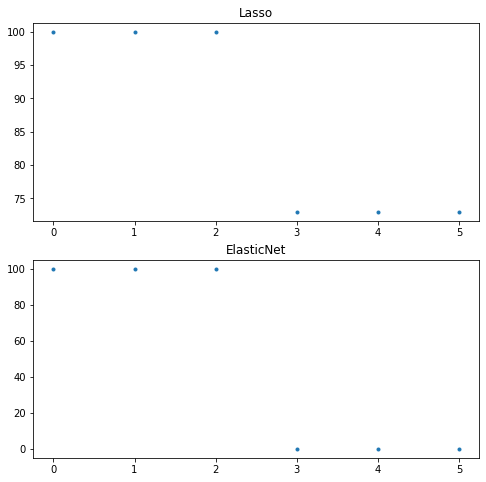

In [6]:
fig, ax = plt.subplots(2, figsize=(8, 8))
ax[0].plot(feature, freq_Lass, '.')
ax[0].set_title('Lasso')
ax[1].plot(feature, freq_Elas, '.')
ax[1].set_title('ElasticNet')

As we can see, in Lasso, all the features are selected more than 50 times so this method is not stable in some specific cases.

Moreover, from another point of view, we can also see the occurrences of each group-feature selection.

In [7]:
from collections import Counter
print("Lasso : ")
print(Counter(map(tuple, lassoRes)))
print("Elastic : ")
print(Counter(map(tuple, ElasticRes)))

Lasso : 
Counter({(0, 1, 2, 3, 4, 5): 31, (0, 1, 2, 3, 4): 21, (0, 1, 2, 4, 5): 18, (0, 1, 2, 3, 5): 18, (0, 1, 2, 5): 6, (0, 1, 2, 4): 3, (0, 1, 2, 3): 3})
Elastic : 
Counter({(0, 1, 2): 100})


We can present it with plots.

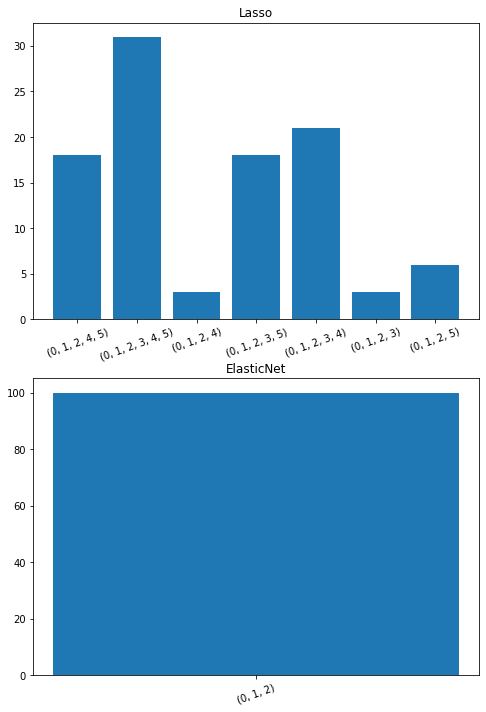

In [8]:
new_lassoRes = Counter(map(tuple, lassoRes))
labels_las, values_las = zip(*new_lassoRes.items())
new_ElasticRes = Counter(map(tuple, ElasticRes))
labels_elas, values_elas = zip(*new_ElasticRes.items())

indexes_las = np.arange(len(labels_las))
indexes_elas = np.arange(len(labels_elas))

fig, ax = plt.subplots(2, figsize=(8, 12))
ax[0].bar(indexes_las, values_las)
ax[0].set_xticks(indexes_las)
ax[0].set_xticklabels(labels_las, rotation=20)
ax[0].set_title('Lasso')
ax[1].bar(indexes_elas, values_elas, width=1)
ax[1].set_xticks(indexes_elas)
ax[1].set_xticklabels(labels_elas, rotation=20)
ax[1].set_title('ElasticNet')
plt.show()

## 5. Conclusion

From the 2 above figures, we find that the selected features of Elastic Net method are always X0, X1 and X2 while the variable selection of Lasso method is not always the same in every case (X3, X4 and X5 are not clearly selected, meaning their frequencies between 20 and 80). Moreover, we can oberve that Lasso is not stable when choosing the group of feature. Consequently, in this particular case, our dataset showed that the feature selection process using ElasticNet is more stable than Lasso.